In [ ]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Creating dataframe by iterating through filepaths
tumor_dir=r'/content/drive/MyDrive/BT1/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
healthy_dir=r'/content/drive/MyDrive/BT1/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
filepaths = []
labels= []
dict_list = [tumor_dir, healthy_dir]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('cancer')
        else:
          labels.append('healthy')

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

#shape of datatset
tumor_df.shape

                                           filepaths  labels
0  /content/drive/MyDrive/BT1/Brain Tumor Data Se...  cancer
1  /content/drive/MyDrive/BT1/Brain Tumor Data Se...  cancer
2  /content/drive/MyDrive/BT1/Brain Tumor Data Se...  cancer
3  /content/drive/MyDrive/BT1/Brain Tumor Data Se...  cancer
4  /content/drive/MyDrive/BT1/Brain Tumor Data Se...  cancer
cancer     179
healthy    107
Name: labels, dtype: int64


(286, 2)

In [ ]:
#splitting data
train_images, test_images = train_test_split(tumor_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)

In [ ]:
#shape of splitted data
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(228, 2)
(86, 2)
(58, 2)
(200, 2)


In [ ]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 228 validated image filenames belonging to 2 classes.
Found 86 validated image filenames belonging to 2 classes.
Found 58 validated image filenames belonging to 2 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['cancer', 'healthy']


In [ ]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

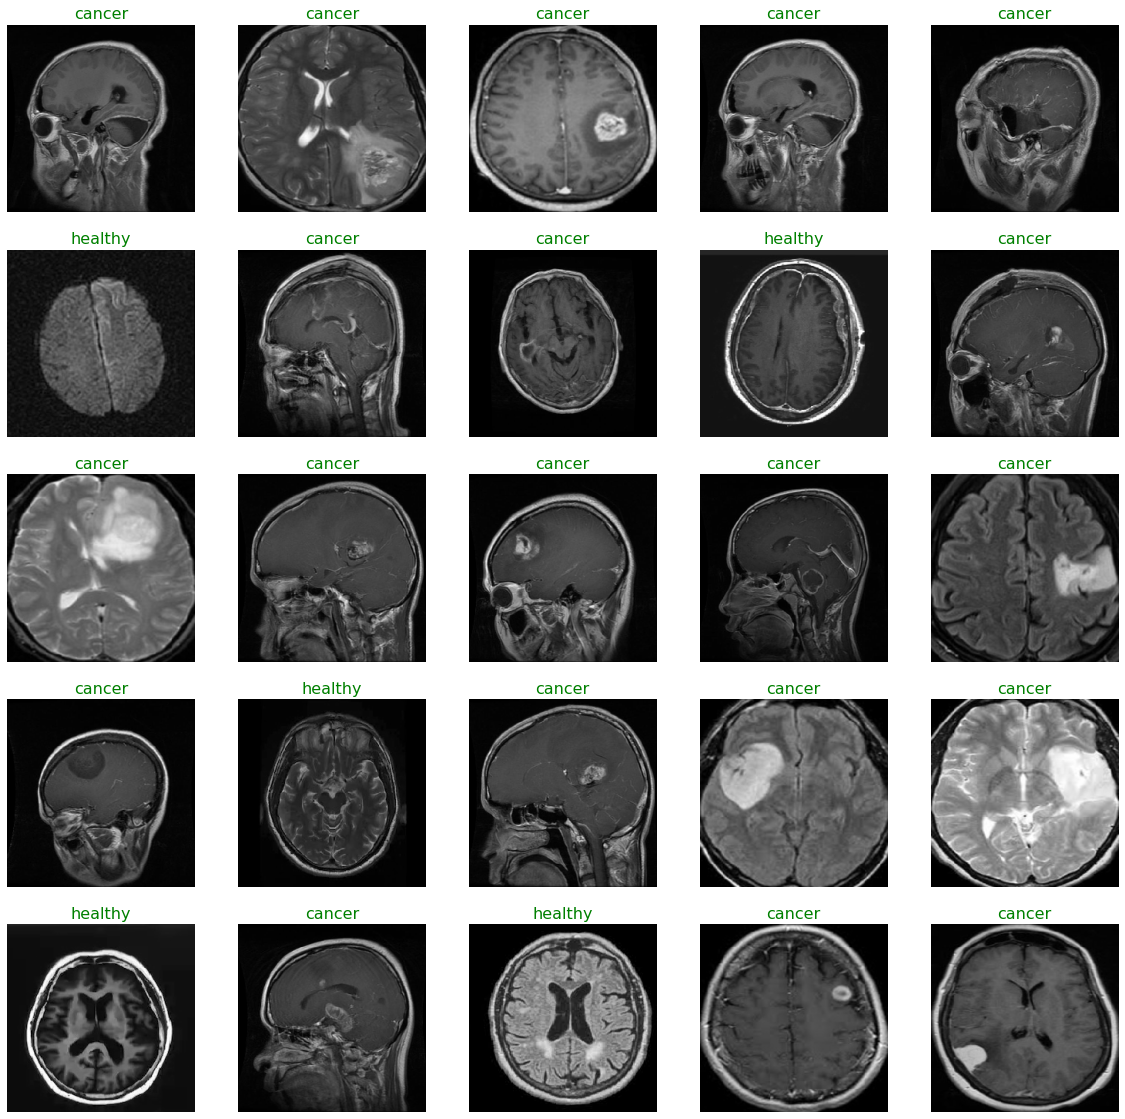

In [ ]:
show_brain_images(train)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.resnet50 import ResNet50
from keras import Model, layers
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.layers import BatchNormalization

model = Sequential()
#vgg-16 , 80% accuracy with 100 epochs
# model.add(VGG16(input_shape=(224,224,3),pooling='avg',classes=1000,weights=vgg16_weights_path))
#resnet-50 , 87% accuracy with 100 epochs
model.add(ResNet50(include_top=False,input_tensor=None,input_shape=(224,224,3),pooling='avg',classes=2,weights="imagenet"))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid'))

model.layers[0].trainable = False
model.summary()
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])


94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 512)              2048      
 er)                                                             
                                                                 
 dense_1 (Dense)             (None, 256)               13

In [ ]:
#fitting model
import time

start = time.time()
History = model.fit(train,validation_data= val, epochs=1,verbose=1)
print("Total time: ", time.time() - start, "seconds")

8/8 [==============================] - 56s 7s/step - loss: 0.8281 - accuracy: 0.5351 - val_loss: 0.6742 - val_accuracy: 0.4655
Total time:  82.11248922348022 seconds


Text(0.5, 1.0, 'Training and Validation Accuracy')

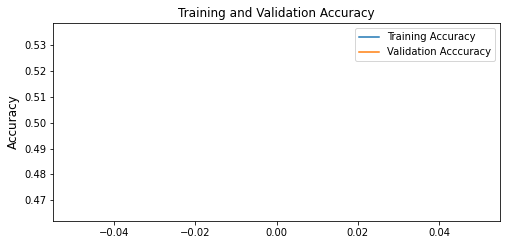

In [ ]:
acc = History.history["accuracy"] # report of model
val_acc = History.history["val_accuracy"] # history of validation data

loss = History.history["loss"]        # Training loss
val_loss = History.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

Text(0.5, 1.0, 'Training and Validation Losses')

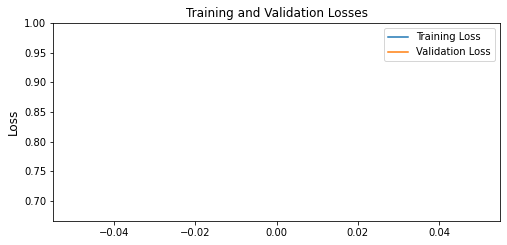

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)

In [ ]:
model.evaluate(test, verbose=1)

3/3 [==============================] - 17s 5s/step - loss: 0.6858 - accuracy: 0.4419


[0.6858100295066833, 0.44186046719551086]

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report,accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:",accuracy_score(y_test, pred2)*100,"%")

              precision    recall  f1-score   support

      cancer       0.80      0.15      0.25        54
     healthy       0.39      0.94      0.56        32

    accuracy                           0.44        86
   macro avg       0.60      0.54      0.40        86
weighted avg       0.65      0.44      0.36        86

Accuracy of the Model: 44.18604651162791 %


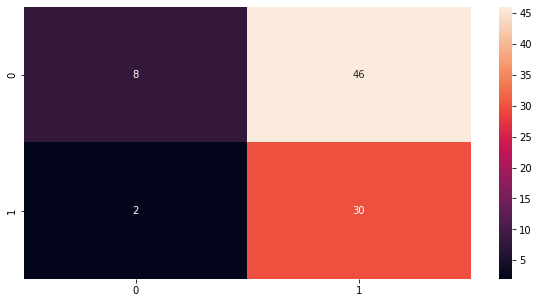

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')